In [1]:
import imageio
import matplotlib.pyplot as plt
import numpy as np
import onnx
import onnxruntime as ort
import torch.onnx

from net import MNISTClassifier

%matplotlib inline

Device found: cuda


In [2]:
def export_to_onnx(net, batch_size, channels, height, width, name='mnist_classification.onnx'):
        print('Saving onnx IR')
        net.eval()
        sample_input_tensor = torch.randn(batch_size, channels, height, width)
        torch.onnx.export(
            net,
            sample_input_tensor,
            name,
            export_params=True,
            opset_version=11,
            do_constant_folding=True,
            input_names=['mnist_data'],
            output_names=['mnist_class'],
            dynamic_axes={'input' : {0 : 'batch_size'}, 'output' : {0 : 'batch_size'}}
        )

In [3]:
model = MNISTClassifier()
model.load_pretrained('mnist.pth')

batch_size = 1
export_to_onnx(model.net.cpu(), batch_size, 1, 28, 28)

Saving onnx IR


/home/filip.grigorov/anaconda3/envs/ml_cuda11.2/lib/python3.9/site-packages/torch/onnx/utils.py:1294: UserWarning: Provided key input for dynamic axes is not a valid input/output name
  warnings.warn("Provided key {} for dynamic axes is not a valid input/output name".format(key))
/home/filip.grigorov/anaconda3/envs/ml_cuda11.2/lib/python3.9/site-packages/torch/onnx/utils.py:1294: UserWarning: Provided key output for dynamic axes is not a valid input/output name
  warnings.warn("Provided key {} for dynamic axes is not a valid input/output name".format(key))


In [4]:
loaded_model = onnx.load('mnist_classification.onnx')
print(onnx.checker.check_model(loaded_model))

None


In [5]:
_, _, test_data = model.split_data()

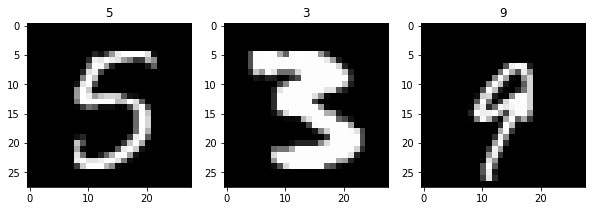

In [6]:
sample_data= [ 
    test_data[0], 
    test_data[1], 
    test_data[2] 
]

TYPE = np.uint8
MEAN = 0.1307
STD = 0.3081

fig, axes = plt.subplots(1, 3, figsize=(10, 10))
axes[0].set_title(sample_data[0][1])
img = sample_data[0][0].numpy().transpose(1, 2, 0)
#img *= STD
#img += MEAN
#img *= 255

axes[0].imshow(img, cmap='gray')
#imageio.imwrite(f'mnist_{sample_data[0][1]}.jpg', img.astype(TYPE))

axes[1].set_title(sample_data[1][1])
img = sample_data[1][0].numpy()
img = img.transpose(1, 2, 0)
#img *= STD
#img += MEAN
#img *= 255

axes[1].imshow(img, cmap='gray')
#imageio.imwrite(f'mnist_{sample_data[1][1]}.jpg', img.astype(TYPE))

axes[2].set_title(sample_data[2][1])
img = sample_data[2][0].numpy().transpose(1, 2, 0)
#img *= STD
#img += MEAN
#img *= 255

axes[2].imshow(img, cmap='gray')
#imageio.imwrite(f'mnist_{sample_data[2][1]}.jpg', img.astype(TYPE))

plt.show()

In [7]:
x = torch.cat([ sample_data[0][0].unsqueeze(0), sample_data[1][0].unsqueeze(0), sample_data[2][0].unsqueeze(0) ], dim=0)
predictions = model.infer(x).numpy()

print(predictions)

[5 3 9]


In [8]:
ort_session = ort.InferenceSession("mnist_classification.onnx")

# Note: No dynamic batching
predictions = []
for x in sample_data:
    x = x[0].unsqueeze(0).cpu().numpy()
    ort_inputs = {ort_session.get_inputs()[0].name: x}
    predictions.append(np.argmax(ort_session.run(None, ort_inputs)))
    
print(predictions)

[5, 3, 9]
